In [1]:
from shared.library import *
import matplotlib.pyplot as plt
# Read the data from the Excel file

excel_file = 'grid_data_sheet.xlsx'

# Usage
net_with_gen = create_network(excel_file)
net_without_gen = create_network_without_gen(excel_file)

# the grid topology is not changed so the protection zone setting should be the same for both cases
Protection_devices = setup_protection_zones(net_with_gen, excel_file)

# Call the function to simulate faults and get protection data
protection_data_with_gen = simulate_faults_for_all_lines(net_with_gen, Protection_devices)
protection_data_without_gen = simulate_faults_for_all_lines(net_without_gen, Protection_devices)

# Convert the list of dictionaries into a DataFrame
protection_df_with_gen = pd.DataFrame(protection_data_with_gen)
protection_df_without_gen = pd.DataFrame(protection_data_without_gen)

This pandapower network includes the following parameter tables:
   - bus (11 element)
   - load (3 element)
   - sgen (7 element)
   - ext_grid (2 element)
   - line (14 element)
   - bus_geodata (11 element)
This pandapower network includes the following parameter tables:
   - bus (11 element)
   - load (3 element)
   - ext_grid (2 element)
   - line (14 element)
   - bus_geodata (11 element)
Simulating faults along line 0
Simulating faults along line 1
Simulating faults along line 2
Simulating faults along line 3
Simulating faults along line 4
Simulating faults along line 5
Simulating faults along line 6
Simulating faults along line 7
Simulating faults along line 8
Simulating faults along line 9
Simulating faults along line 10
Simulating faults along line 11
Simulating faults along line 12
Simulating faults along line 13
Simulating faults along line 0
Simulating faults along line 1
Simulating faults along line 2
Simulating faults along line 3
Simulating faults along line 4
Simulatin

In [ ]:
"""Functions for simple plotting"""


def filter_device_zone_polygon(zone_index, device_index, r_arc, protection_device_list):
    Protection_device_zone = protection_device_list[device_index].associated_zone_impedance[zone_index]
    Protection_device_polygon = Polygon(
        [(0, 0), (-Protection_device_zone.imag * math.tan(math.radians(30)), Protection_device_zone.imag),
         (Protection_device_zone.real + r_arc, Protection_device_zone.imag), (
             Protection_device_zone.real + r_arc,
             -(Protection_device_zone.real + r_arc) * math.tan(math.radians(22)))])
    return Protection_device_polygon


def filter_referred_point(df, device_id, fault_line_id, distance_from_bus):
    filtered_df = df.loc[(df['Device ID'] == device_id) & (df['Fault_line_id'] == fault_line_id) & (
            df['Distance_from_bus'] == distance_from_bus)]
    # Extract the Impedance_calculated value
    if not filtered_df.empty:  # Check if the filtered DataFrame is not empty
        impedance_value = filtered_df['Impedance_calculated'].values[0]
    else:
        print("the simulation result is not generated or the fault simulation case is invalid")
        return None  # Handle the case when no matching row is found
    impedance_point = Point(impedance_value.real, impedance_value.imag)
    return impedance_point


def filter_sensed_point(df, device_id, fault_line_id, distance_from_bus):
    filtered_df = df.loc[(df['Device ID'] == device_id) & (df['Fault_line_id'] == fault_line_id) & (
            df['Distance_from_bus'] == distance_from_bus)]
    # Extract the Impedance_calculated value
    if not filtered_df.empty:  # Check if the filtered DataFrame is not empty
        r_value = filtered_df['r_sensed'].values[0]
        angle_value = filtered_df['angle_sensed'].values[0]
    else:
        print("the simulation result is not generated or the fault simulation case is invalid")
        return None  # Handle the case when no matching row is found

    sensed_point = Point(r_value * math.cos(angle_value * math.pi / 180),
                         r_value * math.sin(angle_value * math.pi / 180))
    return sensed_point


# case 1: after no wind generation,the same device before and after, compare with supposed to be
# device 14
# Define constants and parameters for the plot
r_arc_2_5 = 2.5
device_id = 14
fault_line_id = 6
distance_from_bus = 0.25

# Retrieve polygons for Zone 1 and Zone 2
Protect_14_zone1_polygon = filter_device_zone_polygon(0, device_id, r_arc_2_5, Protection_devices)
Protect_14_zone2_polygon = filter_device_zone_polygon(1, device_id, r_arc_2_5, Protection_devices)

# Retrieve the referred and sensed points for both cases (with and without wind generation)
with_gen_referred = filter_referred_point(protection_df_with_gen, device_id, fault_line_id, distance_from_bus)
with_gen_sensed = filter_sensed_point(protection_df_with_gen, device_id, fault_line_id, distance_from_bus)
without_gen_sensed = filter_sensed_point(protection_df_without_gen, device_id, fault_line_id, distance_from_bus)

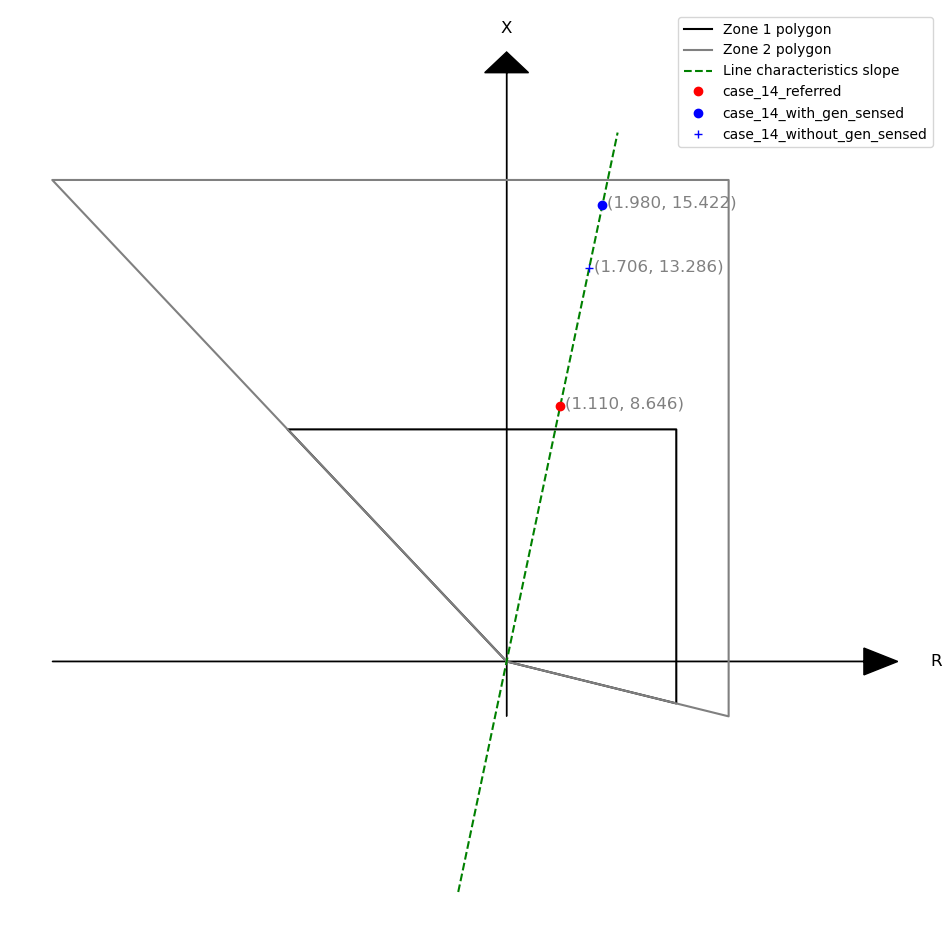

In [7]:
import numpy as np
# Function to plot the polygon
def plot_polygon(polygon, color, label):
    xx, y = polygon.exterior.xy
    plt.plot(xx, y, color=color, label=label)
    return min(xx), max(xx), min(y), max(y)


# Function to plot points with coordinates as labels
def plot_point(point, label, marker, text_color):
    plt.plot(point.x, point.y, marker, label=label)  # Use marker string directly, without color argument
    plt.text(point.x + 0.1, point.y - 0.1, f'({point.x:.3f}, {point.y:.3f})', fontsize=12, color=text_color)


# Set up figure
plt.figure(figsize=(12, 12))

# Plot the polygons for Zone 1 and Zone 2
x_min_1, x_max_1, y_min_1, y_max_1 = plot_polygon(Protect_14_zone1_polygon, 'black', 'Zone 1 polygon')
x_min_2, x_max_2, y_min_2, y_max_2 = plot_polygon(Protect_14_zone2_polygon, 'gray', 'Zone 2 polygon')

# Calculate dynamic limits based on the polygons
x_min, x_max = min(x_min_1, x_min_2), max(x_max_1, x_max_2)
y_min, y_max = min(y_min_1, y_min_2), max(y_max_1, y_max_2)

# Calculate the slope
slope = 0.2600246 / 0.0333925

# Define the range of x-values for the line
x_line = np.linspace(-1, 0.5*x_max, 100)

# Calculate corresponding y-values using the slope, assuming the intercept is zero (through the origin)
y_line = slope * x_line

# Plot the line
plt.plot(x_line, y_line, 'g--', label=f'Line characteristics slope')

# Plot referred and sensed points (with and without wind generation)
plot_point(with_gen_referred, 'case_14_referred', 'ro', 'gray')
plot_point(with_gen_sensed, 'case_14_with_gen_sensed', 'bo', 'gray')
plot_point(without_gen_sensed, 'case_14_without_gen_sensed', 'b+', 'gray')

# Add arrows and labels for X and R axes
arrow_length_x = (x_max - x_min) * 1.2
arrow_length_y = (y_max - y_min) * 1.2
head_width = (y_max - y_min) * 0.05
head_length = (x_max - x_min) * 0.05

plt.arrow(x_min, 0, arrow_length_x, 0, head_width=head_width, head_length=head_length, fc='black', ec='black')
plt.arrow(0, y_min, 0, arrow_length_y, head_width=head_width, head_length=head_length, fc='black', ec='black')
plt.text(x_min + arrow_length_x + head_length + 0.8, 0, 'R', fontsize=12, ha='center', va='center')
plt.text(0, y_min + arrow_length_y + head_length + 0.8, 'X', fontsize=12, ha='center', va='center')

# Adjust plot settings
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# Add legend and show plot
plt.legend(loc='upper right')
plt.show()
